In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque

## 1.定义算法
### 1.1 建立Actor和Critic网络

In [2]:
class Actor(nn.Module):
	
	def __init__(self, n_states, n_actions, hidden_dim = 256):	
		""" 初始化Actor网络，为全连接网络
		"""
		super(Actor, self).__init__()
		self.l1 = nn.Linear(n_states, hidden_dim)
		self.l2 = nn.Linear(hidden_dim, hidden_dim)
		self.l3 = nn.Linear(hidden_dim, n_actions)
	
	def forward(self, state):
		
		x = F.relu(self.l1(state))
		x = F.relu(self.l2(x))
		x = torch.tanh(self.l3(x))
		return x

class Critic(nn.Module):
	def __init__(self, n_states, n_actions, hidden_dim = 256):
		""" 初始化Critic网络，为全连接网络
		"""
		super(Critic,self).__init__()
		self.l1 = nn.Linear(n_states + n_actions, 256)
		self.l2 = nn.Linear(hidden_dim, hidden_dim)
		self.l3 = nn.Linear(hidden_dim, 1)

	def forward(self, state, action):
		sa = torch.cat([state, action], 1)
		q = F.relu(self.l1(sa))
		q = F.relu(self.l2(q))
		q = self.l3(q)
		return q

### 1.2 定义经验回放

In [3]:
class ReplayBufferQue:
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        ''' 存储transition到经验回放中
        '''
        self.buffer.append(transitions)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer): # 如果批量大小大于经验回放的容量，则取经验回放的容量
            batch_size = len(self.buffer)
        if sequential: # 顺序采样
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else: # 随机采样
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        ''' 清空经验回放
        '''
        self.buffer.clear()
    def __len__(self):
         ''' 返回当前存储的量
        '''
        
         return len(self.buffer)

### 1.3 TD3算法

In [4]:
class TD3(object):
	def __init__(self,cfg):
		self.gamma = cfg.gamma # 奖励的折扣因子
		self.actor_lr = cfg.actor_lr # actor学习率
		self.critic_lr = cfg.critic_lr # critic学习率
		self.policy_noise = cfg.policy_noise
		self.noise_clip = cfg.noise_clip
		self.expl_noise = cfg.expl_noise
		self.policy_freq = cfg.policy_freq
		self.batch_size =  cfg.batch_size 
		self.tau = cfg.tau
		self.sample_count = 0
		self.policy_freq = cfg.policy_freq
		self.explore_steps = cfg.explore_steps
		self.device = torch.device(cfg.device)
		self.n_actions = cfg.n_actions
		self.action_space = cfg.action_space
		self.action_scale = torch.tensor((self.action_space.high - self.action_space.low)/2, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
		self.action_bias = torch.tensor((self.action_space.high + self.action_space.low)/2, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
		self.actor = Actor(cfg.n_states, cfg.n_actions, hidden_dim = cfg.actor_hidden_dim).to(self.device)
		self.actor_target = Actor(cfg.n_states, cfg.n_actions, hidden_dim = cfg.actor_hidden_dim).to(self.device)
		self.actor_target.load_state_dict(self.actor.state_dict()) # 复制参数到目标网络

		self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = self.actor_lr)

		self.critic_1 = Critic(cfg.n_states, cfg.n_actions, hidden_dim = cfg.critic_hidden_dim).to(self.device)
		self.critic_2 = Critic(cfg.n_states, cfg.n_actions, hidden_dim = cfg.critic_hidden_dim).to(self.device)
		self.critic_1_target = Critic(cfg.n_states, cfg.n_actions, hidden_dim = cfg.critic_hidden_dim).to(self.device)
		self.critic_2_target = Critic(cfg.n_states, cfg.n_actions, hidden_dim = cfg.critic_hidden_dim).to(self.device)
		self.critic_1_target.load_state_dict(self.critic_1.state_dict()) # 复制参数到目标网络
		self.critic_2_target.load_state_dict(self.critic_2.state_dict()) # 复制参数到目标网络
		
		self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr = self.critic_lr)
		self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr = self.critic_lr)
		self.memory = ReplayBufferQue(cfg.buffer_size)
		# self.memory = ReplayBuffer(n_states, n_actions)

	def sample_action(self, state):
		''' 采样动作
		'''

		self.sample_count += 1
		if self.sample_count < self.explore_steps:
			return self.action_space.sample()
		else:
			state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
			action = self.actor(state)
			action = self.action_scale * action + self.action_bias
			action = action.detach().cpu().numpy()[0]
			action_noise = np.random.normal(0, self.action_scale.cpu().numpy()[0] * self.expl_noise, size=self.n_actions)
			action = (action + action_noise).clip(self.action_space.low, self.action_space.high)
			return action

	@torch.no_grad()
	def predict_action(self, state):
		''' 预测动作
		'''
		state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
		action = self.actor(state)
		action = self.action_scale * action + self.action_bias # 对actor计算的动作分布放缩
		return action.detach().cpu().numpy()[0]

	def update(self):
		# if len(self.memory) < self.batch_size:
		# 	return
		if len(self.memory) < self.explore_steps: # 当经验回放中不满足一个批量时，不更新策略
			return
		state, action, reward, next_state, done = self.memory.sample(self.batch_size) # 从经验回放中随机采样一个批量的转移(transition)
         # 将数据转换为tensor
		state = torch.tensor(np.array(state), device=self.device, dtype=torch.float32)
		action = torch.tensor(np.array(action), device=self.device, dtype=torch.float32)
		next_state = torch.tensor(np.array(next_state), device=self.device, dtype=torch.float32)
		reward = torch.tensor(reward, device=self.device, dtype=torch.float32).unsqueeze(1)
		done = torch.tensor(done, device=self.device, dtype=torch.float32).unsqueeze(1)
		# update critic
		noise = (torch.randn_like(action) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip) # 构造加入目标动作的噪声
        # 计算加入了噪声的目标动作
		next_action = (self.actor_target(next_state) + noise).clamp(-self.action_scale+self.action_bias, self.action_scale+self.action_bias)
        # 计算两个critic网络对t+1时刻的状态动作对的评分，并选取更小值来计算目标q值
		target_q1, target_q2 = self.critic_1_target(next_state, next_action).detach(), self.critic_2_target(next_state, next_action).detach()
		target_q = torch.min(target_q1, target_q2)
		target_q = reward + self.gamma * target_q * (1 - done)
        # 计算两个critic网络对t时刻的状态动作对的评分
		current_q1, current_q2 = self.critic_1(state, action), self.critic_2(state, action)
        # 计算均方根损失
		critic_1_loss = F.mse_loss(current_q1, target_q)
		critic_2_loss = F.mse_loss(current_q2, target_q)
		self.critic_1_optimizer.zero_grad()
		critic_1_loss.backward()
		self.critic_1_optimizer.step()
		self.critic_2_optimizer.zero_grad()
		critic_2_loss.backward()
		self.critic_2_optimizer.step()
		if self.sample_count % self.policy_freq == 0:
            # 延迟策略更新，actor的更新频率低于critic
			actor_loss = -self.critic_1(state, self.actor(state)).mean()
			self.actor_optimizer.zero_grad()
			actor_loss.backward()
			self.actor_optimizer.step()
            #目标网络软更新
			for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
			for param, target_param in zip(self.critic_1.parameters(), self.critic_1_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
			for param, target_param in zip(self.critic_2.parameters(), self.critic_2_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


## 2.模型训练与测试

In [5]:
def train(cfg, env, agent):
    print("开始训练！")
    rewards = [] # 记录所有回合的奖励
    for i_ep in range(cfg.train_eps):
        state = env.reset() # 重置环境，返回初始状态
        ep_reward = 0 # 记录一回合内的奖励
        for i_step in range(cfg.max_steps):
            action = agent.sample_action(state)  # 抽样动作
            next_state, reward, terminated, info = env.step(action)  # 更新环境，返回transitions
            agent.memory.push((state, action, reward,
                            next_state, terminated))  # 保存transition
            agent.update()   # 更新智能体
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if terminated:
                break
        if (i_ep+1)%10 == 0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}")
        rewards.append(ep_reward)
    print("完成训练！")
    return {'rewards':rewards}
def test(cfg, env, agent):
    print("开始测试！")
    rewards = [] # 记录所有回合的奖励
    for i_ep in range(cfg.train_eps):
        state = env.reset() # 重置环境，返回初始状态
        ep_reward = 0 # 记录一回合内的奖励
        for i_step in range(cfg.max_steps):
            action = agent.sample_action(state)  # 抽样动作
            next_state, reward, terminated, info = env.step(action)  # 更新环境，返回transitions
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if terminated:
                break
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.2f}")
    print("完成测试！")
    return {'rewards':rewards}

## 3.定义环境

In [6]:
import gym
import os
import random
def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    env.seed(seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = gym.make(cfg.env_name) # 创建环境
    all_seed(env,seed=cfg.seed)
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.shape[0]
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")
    # 更新n_states和n_actions到cfg参数中
    setattr(cfg, 'n_states', n_states)
    setattr(cfg, 'n_actions', n_actions) 
    setattr(cfg, 'action_space', env.action_space) 
    models = {"actor":Actor(n_states,n_actions,hidden_dim=cfg.actor_hidden_dim),"critic":Critic(n_states,n_actions,hidden_dim=cfg.critic_hidden_dim)}
    memory = ReplayBufferQue(cfg.buffer_size) # 创建经验池
    agent = TD3(cfg)
    return env,agent

/opt/anaconda3/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 4.设置参数

In [7]:
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
class Config:
    def __init__(self):
        self.seed = 123
        self.explore_steps = 5
        self.algo_name = 'TD3' # 算法名称
        self.env_name = 'Pendulum-v1' # 环境名称
        self.device = "cpu" # 使用设备
        self.train_eps = 1000 # 训练迭代次数
        self.test_eps = 50 # 测试迭代次数
        self.eval_eps = 10 # 评估迭代次数
        self.eval_per_episode = 5 # 每隔几代评估
        self.max_steps = 200 # 每次迭代最大时间步
        self.policy_freq = 2  # 策略网络更新频率
        self.actor_lr = 1e-3 
        self.critic_lr = 1e-3 
        self.actor_hidden_dim = 256 # actor网络隐藏层维度
        self.critic_hidden_dim = 256 # critic网络隐藏层维度
        self.gamma = 0.99 
        self.tau = 0.005 # 目标网络软更新系数
        self.policy_noise = 0.2 # 加入策略网络的噪声
        self.expl_noise = 0.1 # 高斯噪声标准差
        self.noise_clip = 0.5 # 加入策略网络噪声范围
        self.batch_size = 100 # 训练批次大小
        self.buffer_size = 1000000 # 经验回放池大小
def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,title="learning curve"):
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{title}")
    plt.xlim(0, len(rewards))  # 设置x轴的范围
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()


/opt/anaconda3/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 5.开始训练

/opt/anaconda3/lib/python3.12/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/opt/anaconda3/lib/python3.12/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/opt/anaconda3/lib/python3.12/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/opt/anaconda3/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for remova

状态空间维度：3，动作空间维度：1
开始训练！


/opt/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


回合：10/1000，奖励：-1526.25
回合：20/1000，奖励：-1165.23
回合：30/1000，奖励：-877.16
回合：40/1000，奖励：-127.72
回合：50/1000，奖励：-114.26
回合：60/1000，奖励：-119.04
回合：70/1000，奖励：-445.09
回合：80/1000，奖励：-224.18
回合：90/1000，奖励：-124.77
回合：100/1000，奖励：-239.87
回合：110/1000，奖励：-2.37
回合：120/1000，奖励：-115.61
回合：130/1000，奖励：-234.39
回合：140/1000，奖励：-118.19
回合：150/1000，奖励：-123.47
回合：160/1000，奖励：-120.91
回合：170/1000，奖励：-114.63
回合：180/1000，奖励：-1513.07
回合：190/1000，奖励：-236.59
回合：200/1000，奖励：-237.62
回合：210/1000，奖励：-130.04
回合：220/1000，奖励：-116.98
回合：230/1000，奖励：-121.18
回合：240/1000，奖励：-1.43
回合：250/1000，奖励：-349.11
回合：260/1000，奖励：-246.09
回合：270/1000，奖励：-122.90
回合：280/1000，奖励：-240.03
回合：290/1000，奖励：-1.66
回合：300/1000，奖励：-116.42
回合：310/1000，奖励：-366.17
回合：320/1000，奖励：-244.19
回合：330/1000，奖励：-123.65
回合：340/1000，奖励：-116.21
回合：350/1000，奖励：-241.39
回合：360/1000，奖励：-334.25
回合：370/1000，奖励：-119.46
回合：380/1000，奖励：-119.45
回合：390/1000，奖励：-249.49
回合：400/1000，奖励：-232.35
回合：410/1000，奖励：-321.67
回合：420/1000，奖励：-1.61
回合：430/1000，奖励：-115.46
回合：440/1000，奖励：-2.92
回合：4

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


回合：12/50，奖励：-126.02
回合：13/50，奖励：-122.63
回合：14/50，奖励：-254.62
回合：15/50，奖励：-234.08
回合：16/50，奖励：-115.93
回合：17/50，奖励：-238.46
回合：18/50，奖励：-114.73
回合：19/50，奖励：-117.15
回合：20/50，奖励：-120.11
回合：21/50，奖励：-123.08
回合：22/50，奖励：-240.79
回合：23/50，奖励：-374.50
回合：24/50，奖励：-123.26
回合：25/50，奖励：-119.85
回合：26/50，奖励：-122.41
回合：27/50，奖励：-121.64
回合：28/50，奖励：-117.99
回合：29/50，奖励：-122.88
回合：30/50，奖励：-0.89
回合：31/50，奖励：-119.74
回合：32/50，奖励：-120.45
回合：33/50，奖励：-246.91
回合：34/50，奖励：-249.11
回合：35/50，奖励：-116.58
回合：36/50，奖励：-124.71
回合：37/50，奖励：-124.51
回合：38/50，奖励：-114.89
回合：39/50，奖励：-116.17
回合：40/50，奖励：-118.06
回合：41/50，奖励：-120.41
回合：42/50，奖励：-118.52
回合：43/50，奖励：-125.56
回合：44/50，奖励：-1.59
回合：45/50，奖励：-0.60
回合：46/50，奖励：-121.01
回合：47/50，奖励：-124.58
回合：48/50，奖励：-125.17
回合：49/50，奖励：-121.43
回合：50/50，奖励：-123.29
回合：51/50，奖励：-351.92
回合：52/50，奖励：-237.61
回合：53/50，奖励：-121.69
回合：54/50，奖励：-368.90
回合：55/50，奖励：-349.42
回合：56/50，奖励：-122.83
回合：57/50，奖励：-120.40
回合：58/50，奖励：-124.73
回合：59/50，奖励：-126.07
回合：60/50，奖励：-236.88
回合：61/50，奖励：-118.73
回合：62/

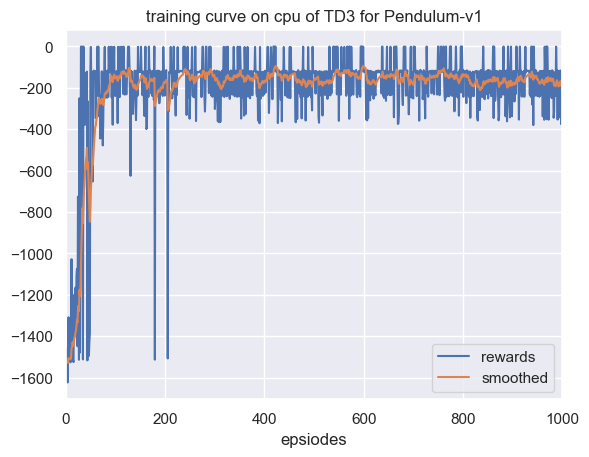

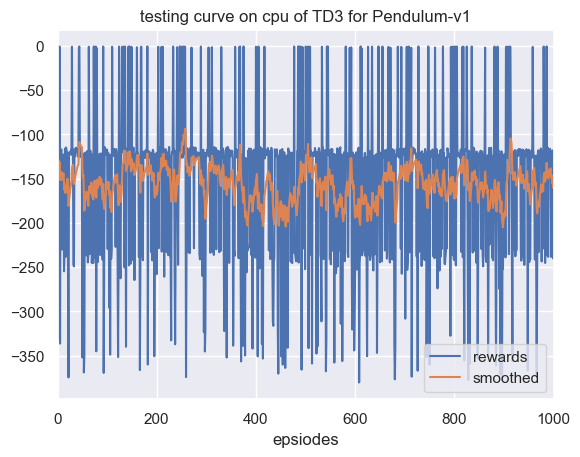

In [8]:
# 获取参数
cfg = Config() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], title=f"training curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], title=f"testing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  # 画出结果